
# Generating Movie Recommendations

### Unsupervised_Learning_ZM6

1. Wendy Ngcobo
2. Mora Magakwe
3. Sandra Malope
4. Katleho Moketo
5. Morris
6. Matthews


## Introduction

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, EDSA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.
******
Recommendation systems are becoming increasingly important in today’s extremely busy world. People are always short on time with the myriad tasks they need to accomplish in the limited 24 hours. Therefore, the recommendation systems are important as they help them make the right choices, without having to expend their cognitive resources.

The purpose of a recommendation system basically is to search for content that would be interesting to an individual. Moreover, it involves a number of factors to create personalised lists of useful and interesting content specific to each user/individual. Recommendation systems are Artificial Intelligence based algorithms that skim through all possible options and create a customized list of items that are interesting and relevant to an individual. These results are based on their profile, search/browsing history, what other people with similar traits/demographics are watching, and how likely are you to watch those movies. This is achieved through predictive modeling and heuristics with the data available.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-challenge/movies.csv
/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-challenge/train.csv
/kaggle/input/edsa-movie-recommendation-challenge/test.csv
/kaggle/input/edsa-movie-recommendation-challenge/tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/links.csv


## Installing packages
Please download all relevant packages in. There is no terminal so you will pip install everything.

You can find a list of recommended install from the Intro to Recommender sysytem notebook.

In [2]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

## Reading in data

In [3]:
df_sample_submission = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv')
df_movies = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/movies.csv')
df_imdb = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv')
df_genome_scores = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv')
df_genome_tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv')
df_train = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/train.csv')
df_test = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/test.csv')
df_tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/tags.csv')
df_links = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/links.csv')

In [4]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_sample_submission.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


## EDA
Discovery phase and data understanding

**Most common Genres**

In [6]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


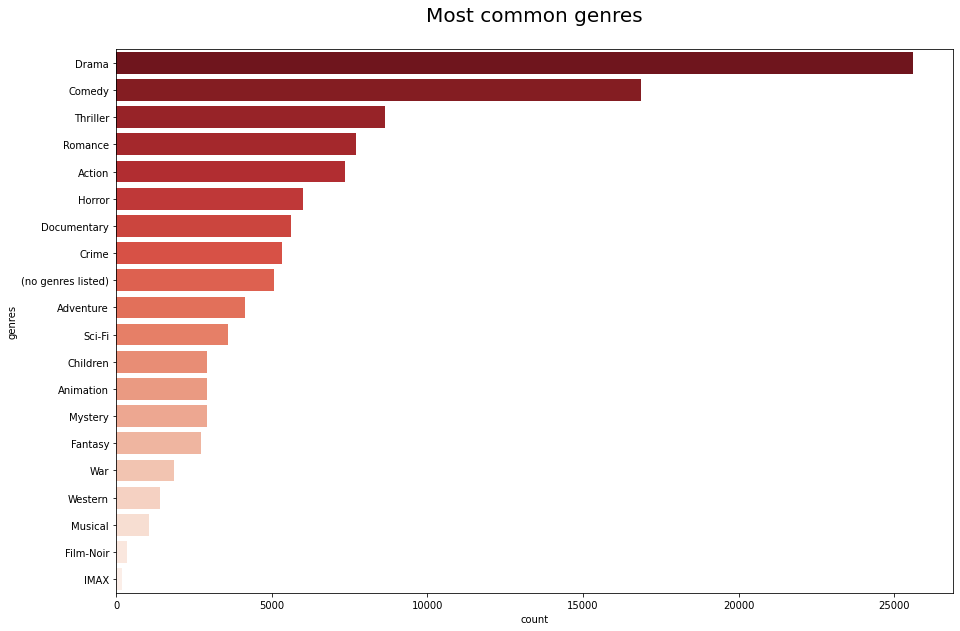

In [7]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

## Data Prepartion

In [8]:
## Here you will sort your data out and process it accordingly

## Modelling phase

Here you can apply the models outline in the Intro to Recommender Notebook. You only need to apply one version 
be it Content based or Collabrative method



In [9]:
# Apply your modelling here

# Generate your outputs here

Prepare Submission File
We make submissions in CSV files. Your submissions usually have two columns: an ID column and a prediction column. The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's to_csv method to write our submission file. Explicitly include the argument index=False to prevent pandas from adding another column in our csv file.

In [10]:
# This is an example
## my_submission = pd.DataFrame({'id': test.Id, 'rating': test.ratings})
# you could use any filename. We choose submission here
## my_submission.to_csv('submission.csv', index=False)


### Make Submission
Hit the blue Publish button at the top of your notebook screen. It will take some time for your kernel to run. When it has finished your navigation bar at the top of the screen will have a tab for Output. This only shows up if you have written an output file (like we did in the Prepare Submission File step).

Example below of how the output would look once published

In [11]:
# initialize list of lists
data = [['tom', 10], ['nick', 15], ['juli', 14]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['Name', 'Age'])
  
# print dataframe.
df

,Name,Age
0,tom,10
1,nick,15
2,juli,14


In [12]:
df.to_csv('my_test_output.csv', index = False)